<h1>Applying K-Nearest Neighbors: Predicting Car Prices</h1>

In the DataQuest Machine Learning course, I explored the fundamentals of machine learning using the k-nearest neighbors algorithm. In this project, I'll practice the machine learning workflow I've learned so far to predict a car's market price using its attributes. The data set I will be working with contains information on various cars. For each car I have information about the technical aspects of the vehicle such as the motor's displacement, the weight of the car, the miles per gallon, how fast the car accelerates, and more.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cars = pd.read_csv('imports-85.data')
cars.head(5)

,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.60,...,130,mpfi,3.47,2.68,9.00,111,5000,21,27,13495
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
1,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
2,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
3,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450
4,2,?,audi,gas,std,two,sedan,fwd,front,99.8,...,136,mpfi,3.19,3.40,8.5,110,5500,19,25,15250


As you can see the data is a little messy. The column names do not match up with the ones in the original data. I will define the column names myself and match them up by passing them into the read_csv call under the names parameter.

In [3]:
cols = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 
        'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type', 
        'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
cars = pd.read_csv('imports-85.data', names=cols)

In [4]:
cars.head(5)

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


For my predictive model I only want feature columns that contain numeric and orginal values. Below I have selected columns that fit this criteria .

In [5]:
ordinal_values_cols = ['normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
car_features = cars[ordinal_values_cols]
car_features.head(5)

,normalized-losses,wheel-base,length,width,height,curb-weight,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,?,88.6,168.8,64.1,48.8,2548,3.47,2.68,9.0,111,5000,21,27,13495
1,?,88.6,168.8,64.1,48.8,2548,3.47,2.68,9.0,111,5000,21,27,16500
2,?,94.5,171.2,65.5,52.4,2823,2.68,3.47,9.0,154,5000,19,26,16500
3,164,99.8,176.6,66.2,54.3,2337,3.19,3.40,10.0,102,5500,24,30,13950
4,164,99.4,176.6,66.4,54.3,2824,3.19,3.40,8.0,115,5500,18,22,17450


When training a predictive model, it is important to not have any missing values. Based on the data set preview from the last step, I can tell that the normalized-losses column contains missing values represented using "?". Let's replace these values and look for the presence of missing values in other numeric columns. Let's also normalize the values in all numeric columns so they have a value between zero and one. That way very large values will not have a greater influence, and everything will be relative.

In [6]:
#Replace all ? values with NaN values
car_features = car_features.replace('?', np.nan)
#Make sure all values are type float
car_features = car_features.astype(float)

Lets detemine how many rows have missing values and in which columns these missing values exist. If it is a significant quantity, I might need to drop the column, otherwise I will just replace missing values with the average.

In [7]:
car_features.isnull().sum()

normalized-losses    41
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

In [8]:
car_features.shape[0]

205

The price column contains our label, and so missing data is a big problem here. I will remove these rows to fix this issue.

In [9]:
car_features = car_features.dropna(subset=['price'])
car_features.isnull().sum()

normalized-losses    37
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 0
dtype: int64

With those rows disposed off, I will replace any remaining null values with the mean value of their respective column.

In [10]:
car_features = car_features.fillna(car_features.mean())

In [11]:
car_features.isnull().sum()

normalized-losses    0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
bore                 0
stroke               0
compression-rate     0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64

Fantastic! No more missing data! Now it is time to normalise the data so that they all scale between 0 and 1. The only column I don't want to normalise it the price, as this is the label I will be using for my predictions.

In [12]:
car_price = car_features['price']
normalised_data = (car_features.max() - car_features)/(car_features.max())
normalised_data['price'] = car_price

In [13]:
normalised_data.head(5)

,normalized-losses,wheel-base,length,width,height,curb-weight,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,0.523438,0.267163,0.188852,0.109722,0.183946,0.373340,0.119289,0.357314,0.608696,0.576336,0.242424,0.571429,0.500000,13495.0
1,0.523438,0.267163,0.188852,0.109722,0.183946,0.373340,0.119289,0.357314,0.608696,0.576336,0.242424,0.571429,0.500000,16500.0
2,0.523438,0.218362,0.177319,0.090278,0.123746,0.305706,0.319797,0.167866,0.608696,0.412214,0.242424,0.612245,0.518519,16500.0
3,0.359375,0.174524,0.151370,0.080556,0.091973,0.425234,0.190355,0.184652,0.565217,0.610687,0.166667,0.510204,0.444444,13950.0
4,0.359375,0.177833,0.151370,0.077778,0.091973,0.305460,0.190355,0.184652,0.652174,0.561069,0.166667,0.632653,0.592593,17450.0


<h2>Univariant K-nearest Neighbours Model</h2>

I will start with a simple univariant model thats making predictions based on a single feature. Starting with simple models before moving to more complex models helps us structure your code workflow and understand the features better.
For now we will use test/train validation, and then later we will try cross validation. So in the function below the data will be split evenly into test/train.

There are two parameters we can vary with K-Nearest Neighbours, the k value (the number of neighbours) and the amount of features we are using for our comparison.

In the function below I will vary the k value, and iterate through each numerical column in the car data. Then I will plot the Root Mean Squared Error for each k value, for each column.

In [14]:
def knn_train_test(df, feature_columns, label_columns,k_range):
    """Instantiate a K-nearest neighbours model and fit
    with data provided
    Keyword Arguments:
    df -- Pandas dataframe
    feature_columns -- columns containing feature elements
    label_columns -- columns containing labels
    k_range -- k values for knn parameters"""
    rmse_values = {}
    #Randomise the dataset
    np.random.seed(1)
    df = df.reindex(np.random.permutation(df.index))
    #Split the data evenly into test set and train set
    split_idx = int(df.shape[0]/2)
    train = df.iloc[0:split_idx]
    test = df.iloc[split_idx:]
    for k in k_range:
        #Instantiate the KNeighborsRegressor class
        knn = KNeighborsRegressor(n_neighbors=k)
        #Fit the model with our data
        knn.fit(train[feature_columns], train[label_columns])
        #Make predictions using the test features
        predictions = knn.predict(test[feature_columns])
        #Calculate the mean squared error of our prediction
        mse = mean_squared_error(test[label_columns], predictions)
        #Return the RMSE by taking the square root of the MSE
        rmse_values[k] = (np.sqrt(mse))
    return rmse_values

In [15]:
feature_columns = normalised_data.columns.drop('price')
column_rmse_values = {}
for col in feature_columns:
    column_rmse_values[col] = knn_train_test(normalised_data,
                                            [col], 'price', 
                                            [1,3,5,7,9])
column_rmse_values

{'bore': {1: 7496.1492312406444,
  3: 6936.9888741632003,
  5: 6816.8537123691885,
  7: 7062.0613050538341,
  9: 6869.7274373649016},
 'city-mpg': {1: 4540.3610032247389,
  3: 4662.4683767438482,
  5: 4729.6734209992692,
  7: 5099.2742894698586,
  9: 4999.2917237740958},
 'compression-rate': {1: 9024.9026779536325,
  3: 7033.5529229950389,
  5: 6736.676353123451,
  7: 7459.1131944220724,
  9: 7219.385481303907},
 'curb-weight': {1: 5518.8832374058084,
  3: 5048.6077260366692,
  5: 4437.9343946355393,
  7: 4369.3490898512136,
  9: 4632.2055452210743},
 'height': {1: 9108.4718365936551,
  3: 8049.9871472883196,
  5: 7487.6525188849646,
  7: 7753.7974180840583,
  9: 7695.632426557866},
 'highway-mpg': {1: 5270.360471073066,
  3: 4618.1866223408379,
  5: 4579.0372499290315,
  7: 4914.2600028726101,
  9: 5181.9124189636359},
 'horsepower': {1: 3749.5962185254293,
  3: 3964.9503610053594,
  5: 4007.4723516831596,
  7: 4391.4816735297054,
  9: 4505.1886320053109},
 'length': {1: 5291.78516454

<function matplotlib.pyplot.show>

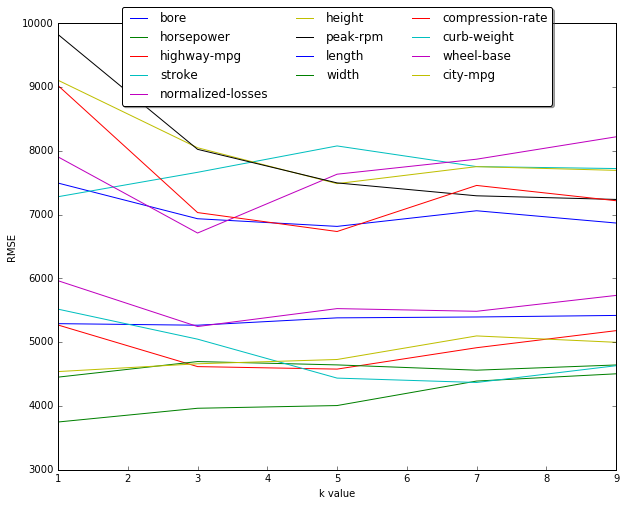

In [16]:
fig = plt.figure(figsize=(10,8))
for k,v in column_rmse_values.items():
    ax = plt.subplot(111)
    lists = sorted(column_rmse_values[k].items())
    x, y = zip(*lists)
    ax.plot(x,y, label = k)
ax.set_xlabel('k value')
ax.set_ylabel('RMSE')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
plt.show

The plot above shows that an optimum k value exists above 3, and the safest bet would be around a value of 5. The columns with the lowest error are 'Horsepower', 'width', 'curb-weight', 'city-mpg', 'highway-mpg', and 'length'. This is possibly suggesting how well known measures of performance, miles per gallon and horsepower, have a powerful influence over price. The other attribute is the size of the vehicle. 

I will now pass in multiple collumns as feature variables to the k-nearest neighbour function I defined earlier, and will therefore be creating a multi-variant model.

In [17]:
#We will use a k value of 5
k = 5
rmse_results = {}
two_best_features = ['horsepower', 'width']
rmse = knn_train_test(normalised_data, two_best_features, 'price',[k])
#The function returns a dictionary, because there is the option
#to use multiple k values. We just want the one result for k = 5
rmse_results[2] = rmse[5]

In [18]:
rmse_results

{2: 3681.3980922556266}

I will now increase the number of features and then plot the results to find the optimum number of features to use

In [19]:
three_best_features = ['horsepower', 'width', 'curb-weight']
four_best_features = ['horsepower', 'width', 'curb-weight', 'city-mpg']
five_best_features = ['horsepower', 'width', 'curb-weight' , 'city-mpg' , 'highway-mpg']
six_best_features = ['horsepower', 'width', 'curb-weight' , 'city-mpg' , 'highway-mpg', 'length']
rmse = knn_train_test(normalised_data, three_best_features, 'price',[k])
rmse_results[3] = rmse[5]
rmse = knn_train_test(normalised_data, four_best_features, 'price',[k])
rmse_results[4] = rmse[5]
rmse = knn_train_test(normalised_data, five_best_features, 'price',[k])
rmse_results[5] = rmse[5]
rmse = knn_train_test(normalised_data, six_best_features, 'price',[k])
rmse_results[6] = rmse[5]

In [20]:
rmse_results

{2: 3681.3980922556266,
 3: 3212.5596306057919,
 4: 3232.1036292326721,
 5: 3346.6737097607775,
 6: 3398.1290113563641}

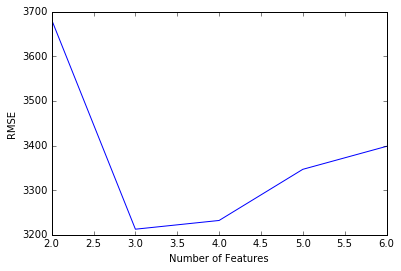

In [21]:
y = [v for k,v in rmse_results.items()]
x = np.arange(2,7,1)
plt.plot(x,y)
plt.xlabel('Number of Features')
plt.ylabel('RMSE')
plt.show()

From the graph above it is clear that the optimum number of features is 3 or 4. I will now vary the k value between 1 and 25 for both these features and then plot the results to find the optimum model

In [22]:
k = np.arange(1,26,1)

In [23]:
rmse_values_3 = knn_train_test(normalised_data, three_best_features, 'price',k)
rmse_values_4 = knn_train_test(normalised_data, four_best_features, 'price',k)

<function matplotlib.pyplot.show>

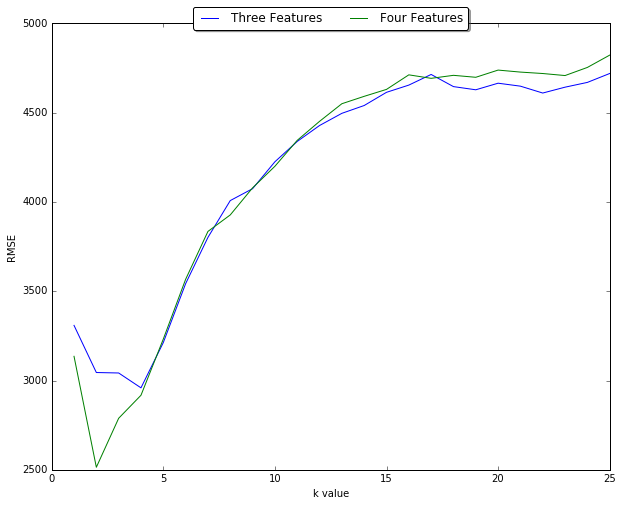

In [24]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111)
y = [v for k,v in rmse_values_3.items()]
x = k
ax.plot(x,y, label = 'Three Features')
y = [v for k,v in rmse_values_4.items()]
x = k
ax.plot(x,y, label = 'Four Features')
ax.set_xlabel('k value')
ax.set_ylabel('RMSE')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
plt.show

The optimal k value when using three features is 5, whereas the optimal value when using four features is 2.
The difference between the k values is on account of the addition of 'city-mpg' to the prediction model. 
The best performance comes from the model that takes four features and uses a k value of 2. 

<h2>K-Fold Cross Validation</h2>

Up until now I have been using train/test validation. In train/test validation the model is repeatedly biased towards a specific subset of the data. K-fold cross validation on the other hand, takes advantage of a larger proportion of the dataset during training, whilst rotating through the data for test subsets, thus avoiding the issues encountered by train/test validation.

The general algorithm is as follows:
* Split the full dataset into k equal length partitions
    * select k-1 partitions as training data
    * select the remaining partition as the test set
* Train the model on the training set to predict labels on the test subset
* Compute the test fold's error metric
* Repeat the above steps k - 1 times, until each partition has been used as the test set for an iteration
* Calculate the mean of the k error values

Generally 5 or 10 folds are used for k-folds cross validation. I will be using 5 folds in my example below.

I will use the best model from above which was using four features and a k value of 2. 

To perform k-fold cross validation I will instantiate an instance of the Kfold class from sklearn.model_selection.
This class returns an iterator object which I can use in conjunction with the cross_val_score() function, also from sklearn.model_selection.

I will specify the parameter 'scoring' to be neg_mean_squared_error' which will return the mean_sqared error for each k fold. 

In [25]:
kf = KFold(n_splits=5,shuffle=True,random_state=1)
knn = KNeighborsRegressor(n_neighbors=2)
mses = cross_val_score(knn,normalised_data[four_best_features],normalised_data['price'],scoring='neg_mean_squared_error',cv=kf)
avg_rmses = np.mean([(np.abs(mse)**(1/2)) for mse in mses])

In [26]:
avg_rmses

2650.2948055326297

Interestingly the RMSE was higher than observed when using test/train validation. This might demonstrate that some bias was being made towards the fixed training set I was using.
Lets use cross validation to see what the optimum k value is when using the four feature model:

In [27]:
k_vals = np.arange(1,26,1)
avg_rmses= {}
for k in k_vals:
    knn = KNeighborsRegressor(n_neighbors=k)
    mses = cross_val_score(knn,normalised_data[four_best_features],normalised_data['price'],scoring='neg_mean_squared_error',cv=kf)
    avg_rmses[k] = np.mean([(np.abs(mse)**(1/2)) for mse in mses])

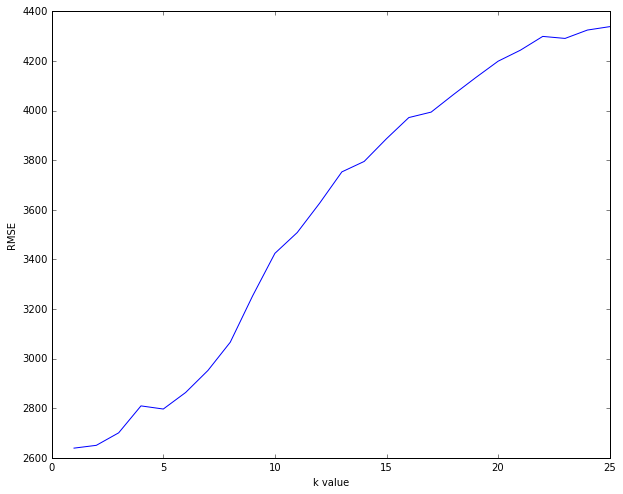

In [28]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111)
y = [v for k,v in avg_rmses.items()]
x = k_vals
ax.set_xlabel('k value')
ax.set_ylabel('RMSE')
ax.plot(x,y)
plt.show()

A k-value of 2 is still optimal, so we shall remain with this k-value. I shall now use cross-validation to find the best number of features to use, ranging from three to eight:

In [29]:
seven_best_features = ['horsepower', 'width', 'curb-weight' , 'city-mpg' , 'highway-mpg', 'length', 'wheel-base']
eight_best_features = ['horsepower', 'width', 'curb-weight' , 'city-mpg' , 'highway-mpg', 'length', 'wheel-base','bore']
knn = KNeighborsRegressor(n_neighbors=2)
avg_rmses= {}
features = [three_best_features, four_best_features, five_best_features,six_best_features,seven_best_features,eight_best_features]
idx = 3
for f in features:    
    mses = cross_val_score(knn,normalised_data[f],normalised_data['price'],scoring='neg_mean_squared_error',cv=kf)
    avg_rmses[idx] = np.mean([(np.abs(mse)**(1/2)) for mse in mses])
    idx += 1
avg_rmses

{3: 2777.2808125930624,
 4: 2650.2948055326297,
 5: 2589.2881025793604,
 6: 2545.1436010538596,
 7: 2543.434693706763,
 8: 2753.7521087360119}

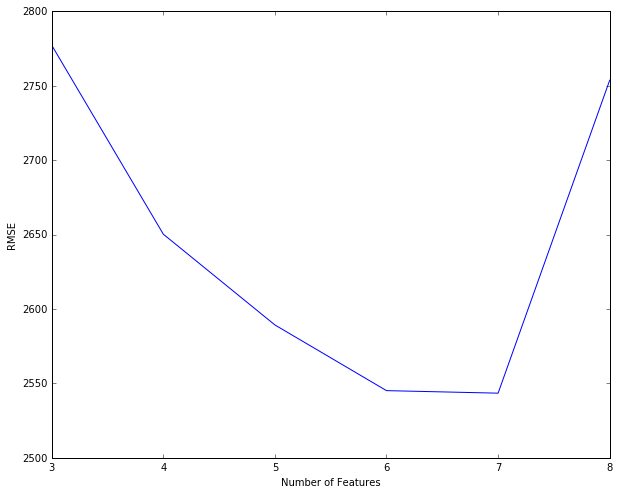

In [30]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111)
y = [v for k,v in avg_rmses.items()]
x = np.arange(3,9,1)
ax.plot(x,y)
ax.set_xlabel('Number of Features')
ax.set_ylabel('RMSE')
plt.show()

So, in conclusion, by using cross-validation instead of test/train, we can conclude that the optimal k value is indeed 2, but by using 7 features instead of 4, we can achieve a much better RMSE.

It should bbe noted however that the RMSE value does not give the whole picture, and a low RMSE is not always suggestive of an accurate model. A model has two sources of error, bias and variance.

Bias is the result of bad assumptions, for example the assumption that a certain car feature relates to price. Variance, is error that occurs due to the variability of a model's predictions. If our dataset contained 1000 features, and we used all of them to train an incredibly complicated multivariant model, we will have very low bias but very high variance.

In an ideal world, we want low bias but also low variance, but in reality it is a trade-off between the two.

The average RMSE is a good measure of a model's bias, which is what we have above. To measure variance, we can use the standard deviation of the RMSE values. 

In [31]:
seven_best_features = ['horsepower', 'width', 'curb-weight' , 'city-mpg' , 'highway-mpg', 'length', 'wheel-base']
eight_best_features = ['horsepower', 'width', 'curb-weight' , 'city-mpg' , 'highway-mpg', 'length', 'wheel-base','bore']
knn = KNeighborsRegressor(n_neighbors=2)
std_rmses = {}
avg_rmses= {}
features = [three_best_features, four_best_features, five_best_features,six_best_features,seven_best_features,eight_best_features]
idx = 3
for f in features:    
    mses = cross_val_score(knn,normalised_data[f],normalised_data['price'],scoring='neg_mean_squared_error',cv=kf)
    avg_rmses[idx] = np.mean([(np.abs(mse)**(1/2)) for mse in mses])
    std_rmses[idx] = np.std([(np.abs(mse)**(1/2)) for mse in mses])
    idx += 1
print(avg_rmses)
print(std_rmses)

{3: 2777.2808125930624, 4: 2650.2948055326297, 5: 2589.2881025793604, 6: 2545.1436010538596, 7: 2543.434693706763, 8: 2753.7521087360119}
{3: 507.39753334430156, 4: 671.99569448092927, 5: 578.96677279927769, 6: 540.04969380871387, 7: 423.89142813070202, 8: 358.37575810568154}


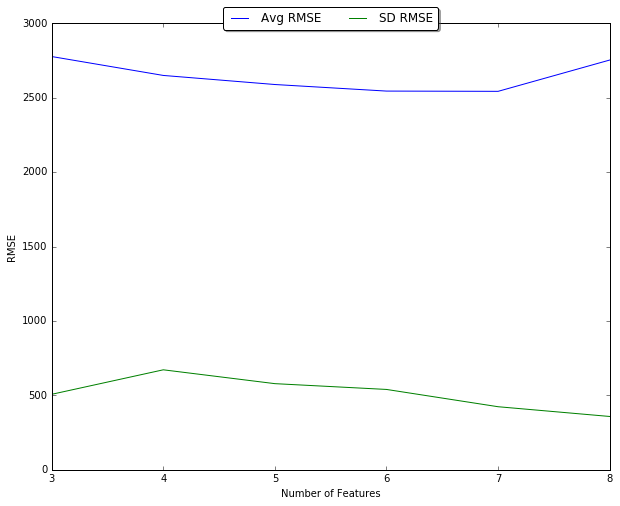

In [32]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111)
y = [v for k,v in avg_rmses.items()]
x = np.arange(3,9,1)
ax.plot(x,y, label='Avg RMSE')
y = [v for k,v in std_rmses.items()]
x = np.arange(3,9,1)
ax.plot(x,y, label='SD RMSE')

ax.set_xlabel('Number of Features')
ax.set_ylabel('RMSE')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
plt.show()

My conclusions remain very much the same, but I hope this has demonstrated how K-Nearest Neighbors can be applied to make predictions, and how hyperparameters can be adjusted, whilst investigating results with the correct validation methods, to produce the optimal models.